# Домашнее задание. Классификация изображений

мой id team на kaggle: Константин_Беклемишев_778932 score: 0.99787

Мой профиль на kaggle: https://www.kaggle.com/hekzir

Ник в телеграмме: @starkhv



### Установка зависимостей

In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [2]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [49]:
# Аугментация изображений 
trfs = {
    'train': transforms.Compose([
        transforms.Resize(224, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(-25,25)),
        transforms.CenterCrop(244),
        transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224,  antialias=True),
        transforms.CenterCrop(244),
        transforms.Lambda(lambda x: np.array(x, dtype='float32') / 255),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [50]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'test':
            transform = trfs['test']
        else:
            transform = trfs['train']
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./data/train/')
TEST_DIR = Path('./data/testset')

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

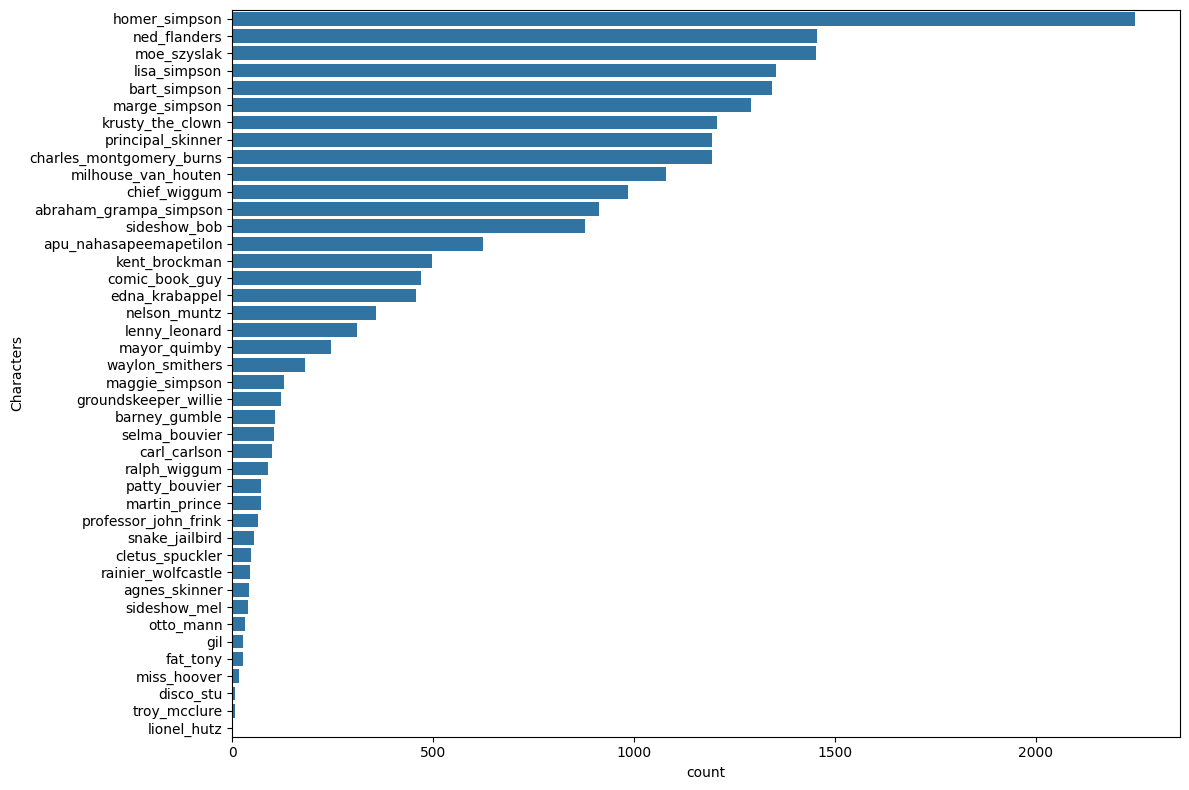

In [8]:
plt.figure(figsize=(12,8))
counts = pd.Series(train_val_labels).value_counts()
sns.barplot(x=counts.sort_values(ascending=False), y=counts.keys())
plt.ylabel('Characters')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Давайте посмотрим на наших героев внутри датасета.

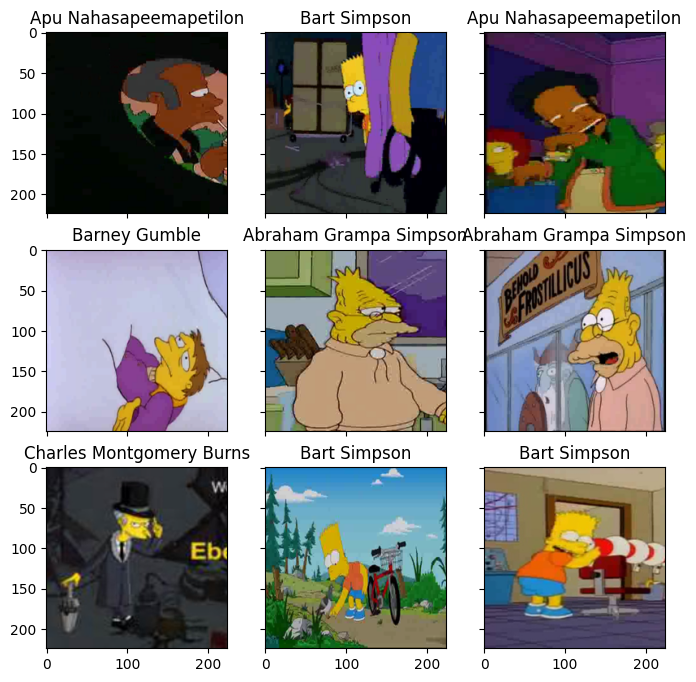

In [12]:
val_dataset = SimpsonsDataset(train_files, mode='val')

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [10]:
# Простая сеть взята из ноутбука https://www.kaggle.com/code/ndyarrrr/1-0-score-with-baseline-model-3fc/notebook
class SimpleCnn(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [64]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_loader, val_loader,  model, opt, criterion, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [65]:
def train_wo_val(train_loader,  model, opt, criterion, scheduler, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)

            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                            t_acc=train_acc))

    return history

In [56]:
# Загурзка данных
BATCH_SIZE=128

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(train_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')
full_dataset = SimpsonsDataset(train_val_files, mode='train')

counts = pd.Series(train_val_labels).value_counts()
count_weights = {name: 1/count for name, count in counts.items()}
sample_weights = [count_weights[label] for label in full_dataset.labels]

train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
train_loader_norm = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, num_workers=4,  shuffle=True)
full_loader_norm = DataLoader(full_dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=train_sampler)

In [80]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
optimazer = torch.optim.Adam(simple_cnn.parameters(), lr=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimazer, step_size=7, gamma=0.2)
criterion = nn.CrossEntropyLoss()

In [81]:
history = train_wo_val(full_loader, simple_cnn, optimazer, criterion, scheduler, epochs=28)

epoch:   4%|▎         | 1/28 [00:23<10:45, 23.91s/it]

loss 3.0079808609658634

Epoch 001 train_loss: 3.0080     train_acc 0.1350


epoch:   7%|▋         | 2/28 [00:48<10:25, 24.06s/it]

loss 1.9693300586784814

Epoch 002 train_loss: 1.9693     train_acc 0.4370


epoch:  11%|█         | 3/28 [01:12<10:01, 24.07s/it]

loss 1.2540708319750062

Epoch 003 train_loss: 1.2541     train_acc 0.6435


epoch:  14%|█▍        | 4/28 [01:36<09:36, 24.03s/it]

loss 0.9088366363340469

Epoch 004 train_loss: 0.9088     train_acc 0.7411


epoch:  18%|█▊        | 5/28 [02:00<09:11, 23.98s/it]

loss 0.7143637457317842

Epoch 005 train_loss: 0.7144     train_acc 0.7947


epoch:  21%|██▏       | 6/28 [02:23<08:46, 23.93s/it]

loss 0.5629369772745376

Epoch 006 train_loss: 0.5629     train_acc 0.8365


epoch:  25%|██▌       | 7/28 [02:47<08:21, 23.87s/it]

loss 0.48362693626084624

Epoch 007 train_loss: 0.4836     train_acc 0.8598


epoch:  29%|██▊       | 8/28 [03:11<07:57, 23.88s/it]

loss 0.29695667695900624

Epoch 008 train_loss: 0.2970     train_acc 0.9143


epoch:  32%|███▏      | 9/28 [03:35<07:33, 23.86s/it]

loss 0.24167911369727788

Epoch 009 train_loss: 0.2417     train_acc 0.9299


epoch:  36%|███▌      | 10/28 [03:59<07:10, 23.89s/it]

loss 0.20866007508925985

Epoch 010 train_loss: 0.2087     train_acc 0.9414


epoch:  39%|███▉      | 11/28 [04:23<06:46, 23.94s/it]

loss 0.1779070421939441

Epoch 011 train_loss: 0.1779     train_acc 0.9473


epoch:  43%|████▎     | 12/28 [04:47<06:23, 23.99s/it]

loss 0.16143941381973878

Epoch 012 train_loss: 0.1614     train_acc 0.9543


epoch:  46%|████▋     | 13/28 [05:11<05:59, 23.97s/it]

loss 0.1386240623033218

Epoch 013 train_loss: 0.1386     train_acc 0.9618


epoch:  50%|█████     | 14/28 [05:35<05:35, 23.96s/it]

loss 0.11843674458833475

Epoch 014 train_loss: 0.1184     train_acc 0.9657


epoch:  54%|█████▎    | 15/28 [05:59<05:11, 23.97s/it]

loss 0.09217007708033835

Epoch 015 train_loss: 0.0922     train_acc 0.9753


epoch:  57%|█████▋    | 16/28 [06:23<04:47, 23.99s/it]

loss 0.08383136399092782

Epoch 016 train_loss: 0.0838     train_acc 0.9766


epoch:  61%|██████    | 17/28 [06:47<04:23, 23.97s/it]

loss 0.07973377561068641

Epoch 017 train_loss: 0.0797     train_acc 0.9780


epoch:  64%|██████▍   | 18/28 [07:11<03:59, 24.00s/it]

loss 0.07696804256087099

Epoch 018 train_loss: 0.0770     train_acc 0.9793


epoch:  68%|██████▊   | 19/28 [07:35<03:36, 24.03s/it]

loss 0.06866777093371597

Epoch 019 train_loss: 0.0687     train_acc 0.9823


epoch:  71%|███████▏  | 20/28 [07:59<03:12, 24.07s/it]

loss 0.06745241446501435

Epoch 020 train_loss: 0.0675     train_acc 0.9837


epoch:  75%|███████▌  | 21/28 [08:23<02:48, 24.07s/it]

loss 0.06205111148051808

Epoch 021 train_loss: 0.0621     train_acc 0.9838


epoch:  79%|███████▊  | 22/28 [08:47<02:24, 24.04s/it]

loss 0.058353377142826325

Epoch 022 train_loss: 0.0584     train_acc 0.9850


epoch:  82%|████████▏ | 23/28 [09:11<02:00, 24.06s/it]

loss 0.056051622355274146

Epoch 023 train_loss: 0.0561     train_acc 0.9851


epoch:  86%|████████▌ | 24/28 [09:35<01:36, 24.06s/it]

loss 0.05704418211582398

Epoch 024 train_loss: 0.0570     train_acc 0.9842


epoch:  89%|████████▉ | 25/28 [09:59<01:12, 24.04s/it]

loss 0.05173649127604781

Epoch 025 train_loss: 0.0517     train_acc 0.9869


epoch:  93%|█████████▎| 26/28 [10:23<00:48, 24.05s/it]

loss 0.05599001984476833

Epoch 026 train_loss: 0.0560     train_acc 0.9856


epoch:  96%|█████████▋| 27/28 [10:47<00:24, 24.06s/it]

loss 0.05579199296090536

Epoch 027 train_loss: 0.0558     train_acc 0.9848


epoch: 100%|██████████| 28/28 [11:12<00:00, 24.01s/it]

loss 0.054391963803808875

Epoch 028 train_loss: 0.0544     train_acc 0.9852


In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [66]:
probs = predict(simple_cnn, test_dataloader)

In [67]:
# Выгрузим файл  submit.csv
preds = train_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
pd.DataFrame({'Id': test_filenames, 'Expected':preds}).to_csv('submit_3.csv', index=False)